In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import geopandas as gpd
import h3pandas 
sys.path.append('../../../reproducible_figures/scripts/')
import rep_fig_vis as rfv
sys.path.append('../../scripts/')
import create_dataset_utils as cdu
sys.path.append('../../../cnn-land-cover/scripts/')
import land_cover_analysis as lca 
import land_cover_visualisation as lcv

sys.path.append('../../scripts/')
import create_dataset_utils as cdu
import paired_embeddings_models as pem
import data_vis_utils as dvu
import shapely
from tqdm import tqdm, tqdm_notebook
import os
import pandas as pd

Font size is set to 10


In [64]:
ds = pem.DataSetImagePresence(image_folder='/Users/t.vanderplas/data/UKBMS_sent2_ds/sent2-4band/mix-2018-2019/m-06-09/',
                              presence_csv='/Users/t.vanderplas/data/UKBMS_sent2_ds/bms_presence/bms_presence_y-2018-2019_th-200.csv',
                              species_process='all',
                              zscore_im=True, 
                              augment_image=False, mode='val')

tmp = dvu.print_table_results_per_species(ds=ds, filepath_train_val_split='../../content/split_indices_2024-03-04-1831.pth',
                                          save_table=True)

Font size is set to 10
Found 1329 out of 1455 images in the image folder.
Sorting data by name_loc.
Number of samples in train set: 947
Number of samples in val set: 196
Number of samples in test set: 186


In [59]:
tmp

,species,P(presence) train [\%],P(presence) val [\%],P(presence) test [\%]
0,Melanargia galathea,10.61,12.36,14.10
1,Pieris napi,37.77,36.88,37.70
2,Aphantopus hyperantus,23.88,24.12,25.74
3,Aglais io,31.16,30.56,30.29
4,Polyommatus icarus,35.88,39.20,41.89
...,...,...,...,...
57,Melitaea cinxia,0.06,0.00,0.00
58,Carterocephalus palaemon,0.12,0.00,0.00
59,Nymphalis polychloros,0.00,0.04,0.01
60,Nymphalis antiopa,0.01,0.00,0.00


In [42]:
tmp = dvu.print_table_mlplayers_pretrained(save_table=True)
tmp = dvu.print_table_mlplayers_pretrained_lr(save_table=True)

Font size is set to 10
Loaded stats from PECL-ImEn_2024-03-04-2244_vnum-324_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-04-2302_vnum-325_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-04-2321_vnum-326_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-04-2339_vnum-327_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-04-2357_vnum-328_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-0016_vnum-329_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-0035_vnum-330_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-0053_vnum-331_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-0112_vnum-332_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024

In [39]:
tmp[1]

,MLP,Pretrained,Top-10 [\%],Top-5 [\%],MSE [1e-02]
0,nan,Mean rates,67.3,58.7,1.39
1,1.0,ImageNet,68.9 $\pm$ 0.8,60.9 $\pm$ 1.0,1.33 $\pm$ 0.05
2,1.0,SeCo,69.1 $\pm$ 0.5,61.8 $\pm$ 0.9,1.34 $\pm$ 0.04
3,2.0,ImageNet,\textbf{69.7 $\pm$ 0.5},61.5 $\pm$ 0.7,1.24 $\pm$ 0.03
4,2.0,SeCo,69.5 $\pm$ 0.4,\textbf{62.4 $\pm$ 0.8},1.22 $\pm$ 0.04
5,3.0,ImageNet,69.0 $\pm$ 0.5,61.8 $\pm$ 0.7,1.24 $\pm$ 0.03
6,3.0,SeCo,69.6 $\pm$ 0.2,62.4 $\pm$ 1.0,\textbf{1.21 $\pm$ 0.04}


In [21]:
tmp = dvu.print_table_test(split_use='test')

Font size is set to 10
Loaded stats from PECL-ImEn_2024-03-05-1941_vnum-380_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2000_vnum-381_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2018_vnum-382_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2036_vnum-383_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2055_vnum-384_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2113_vnum-385_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Hyperparameter alpha_ratio_loss has 2 unique values
Hyperparameter seed_used has 3 unique values
No hyperparameters to show specified, using ['alpha_ratio_loss']
Dropping metric test_top_20_acc
Dropping metric test_top_1_acc
Dropping metric test_bce_loss
Dropping metric test_mae_loss


In [22]:
tmp[0]

alpha_ratio_loss    Top-10               Top-5                 MSE          
                        mean       sem      mean       sem      mean       sem
0              0.0  0.696237  0.003580  0.622222  0.009089  0.012278  0.000364
1              0.1  0.698387  0.008118  0.623298  0.008267  0.012244  0.000254

In [23]:
tmp[1]

,$\alpha$,Top-10 [\%],Top-5 [\%],MSE [1e-02]
0,0.0,69.6 $\pm$ 0.4,62.2 $\pm$ 0.9,1.23 $\pm$ 0.04
1,0.1,\textbf{69.8 $\pm$ 0.8},\textbf{62.3 $\pm$ 0.8},\textbf{1.22 $\pm$ 0.03}


Loaded stats from PECL-ImEn_2024-03-05-1610_vnum-374_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-1628_vnum-375_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-1647_vnum-376_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-1705_vnum-377_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-1848_vnum-378_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-1908_vnum-379_stats.pkl at /Users/t.vanderplas/models/PECL/stats/


/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Loaded stats from PECL-ImEn_2024-03-05-1941_vnum-380_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2000_vnum-381_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2018_vnum-382_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2036_vnum-383_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2055_vnum-384_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2113_vnum-385_stats.pkl at /Users/t.vanderplas/models/PECL/stats/


/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Loaded stats from PECL-ImEn_2024-03-05-1610_vnum-374_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-1628_vnum-375_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-1647_vnum-376_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-1705_vnum-377_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-1848_vnum-378_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-1908_vnum-379_stats.pkl at /Users/t.vanderplas/models/PECL/stats/


/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Loaded stats from PECL-ImEn_2024-03-05-1941_vnum-380_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2000_vnum-381_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2018_vnum-382_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2036_vnum-383_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2055_vnum-384_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2113_vnum-385_stats.pkl at /Users/t.vanderplas/models/PECL/stats/


/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


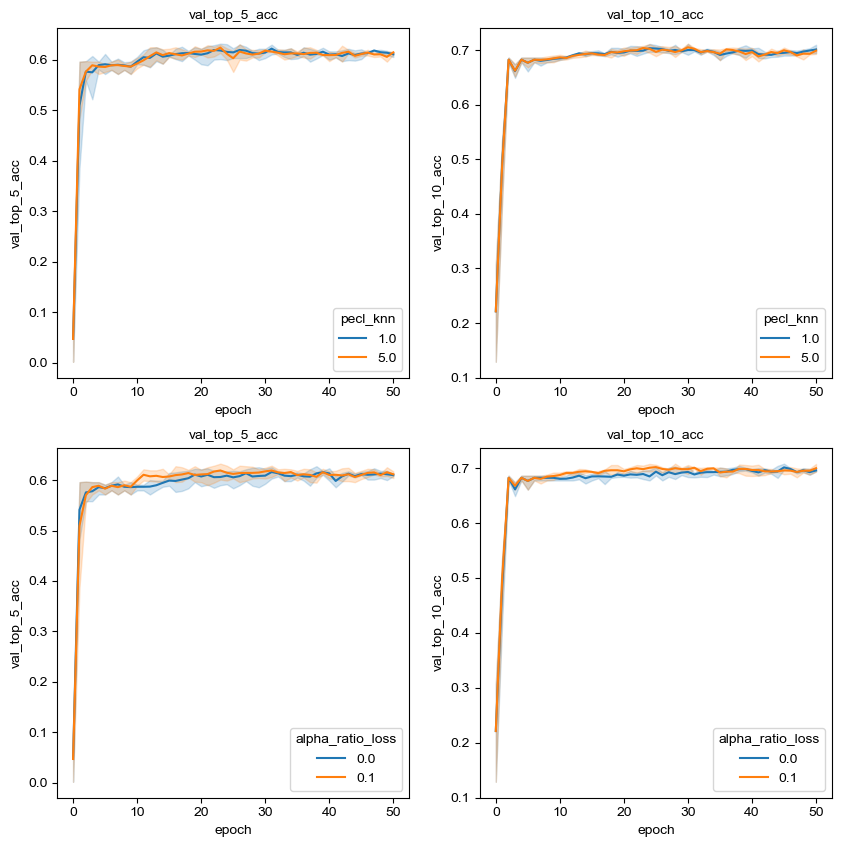

In [91]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for i_plot, metric in enumerate(['val_top_5_acc', 'val_top_10_acc']):
    tmp = dvu.plot_val_timeseries(list_ts=dvu.get_list_timestamps_from_vnums(np.arange(374, 380)),
                              metric_show=metric, ax=ax[0, i_plot])
    ax[0, i_plot].set_title(metric)
    tmp = dvu.plot_val_timeseries(list_ts=dvu.get_list_timestamps_from_vnums(np.arange(380, 386)),
                              metric_show=metric, ax=ax[1, i_plot])
    ax[1, i_plot].set_title(metric)

In [72]:
tmp.head(60)

,epoch,alpha_ratio_loss,val_top_20_acc,val_top_10_acc,val_top_5_acc,val_top_1_acc,val_bce_loss,val_mse_loss,val_mae_loss
0,0,0.0,0.337109,0.228125,0.043750,0.000000,0.694901,0.190222,0.412082
1,1,0.0,0.607908,0.421429,0.482653,0.443878,0.420164,0.062250,0.230518
2,2,0.0,0.841327,0.677551,0.571429,0.117347,0.253702,0.016333,0.066210
3,3,0.0,0.841327,0.660714,0.579592,0.443878,0.240614,0.015041,0.067817
4,4,0.0,0.841327,0.677551,0.571429,0.443878,0.237303,0.014130,0.067241
5,5,0.0,0.841327,0.660714,0.571429,0.443878,0.236689,0.014094,0.065338
6,6,0.0,0.841327,0.677551,0.579592,0.443878,0.236315,0.013986,0.064537
7,7,0.0,0.841327,0.677551,0.571429,0.443878,0.236161,0.014010,0.064945
8,8,0.0,0.841327,0.677551,0.579592,0.443878,0.235817,0.013952,0.064817
9,9,0.0,0.841327,0.677551,0.571429,0.443878,0.235811,0.013967,0.065620
